# NOI: Zufallsprozesse und Quantisierung im Frequenzbereich #
## NOI_intro: Einfluss der Quantisierung im Frequenzbereich ##

In diesem Notebook wird ein Sinussignal auf eine vorgegebene Anzahl von
Vor- und Nachkommabits quantisiert mit verschiedenen Quantisierungs- und Overflowmethoden.

In [10]:
import os, sys
module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
import dsp_fpga_fix_lib as fx   

import numpy as np
from numpy import (pi, log10, exp, sqrt, sin, cos, tan, angle, arange,
                    linspace, array, zeros, ones)
from numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq

import matplotlib.pyplot as plt
from matplotlib.pyplot import (figure, plot, stem, grid, xlabel, ylabel,
    subplot, title, clf, xlim, ylim)
%matplotlib inline

figsize = {"figsize":(15,10)}

Anzahl der Überläufe =  0


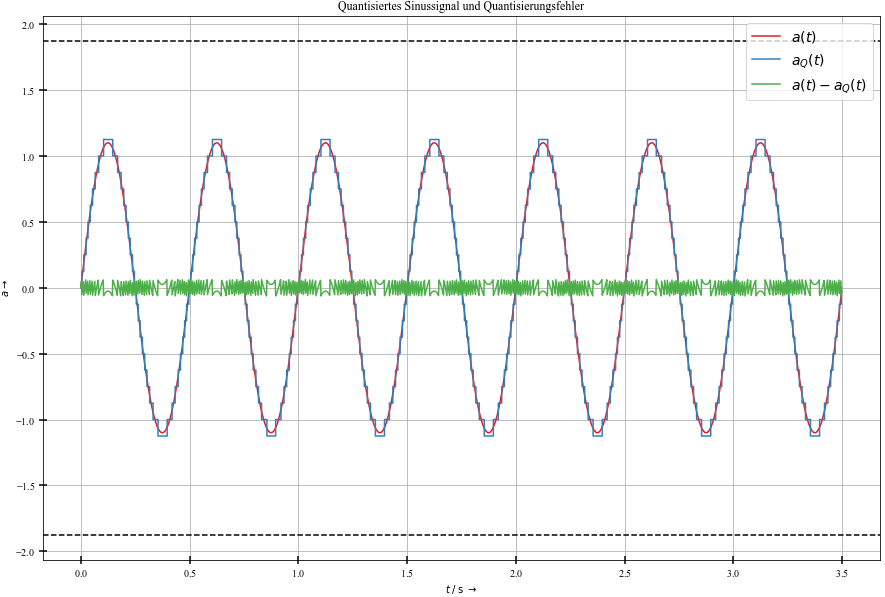

In [11]:
NOISE_LABEL = True # add second axis for noise power density
NFFT = 2000; f_a = 2; N_per = 7
T_mess = N_per / f_a; T_S = T_mess / NFFT
t = linspace(0, T_mess, NFFT, endpoint=False)
a = 1.1 * sin(2 * pi * f_a * t)
#
q_obj = {'WI':1, 'WF': 3, 'quant':'round', 'ovfl': 'wrap'} # versuchen Sie auch 'floor' / 'fix' und 'sat'
fx_a = fx.Fixed(q_obj)
aq = fx_a.fixp(a)

print('Anzahl der Überläufe = ', fx_a.N_over)
#
fig1 = figure(1, **figsize)
ax1 = fig1.add_subplot(111)
ax1.set_title('Quantisiertes Sinussignal und Quantisierungsfehler')
ax1.plot(t, a, label = r'$a(t)$')
ax1.step(t, aq, where = 'post', label = r'$a_Q(t)$')
ax1.plot(t, a-aq, label = r'$a(t) - a_Q(t)$')
ax1.legend(fontsize = 14)
ax1.set_xlabel(r'$t \; \mathrm{/ \; s} \; \rightarrow$'); ax1.set_ylabel(r'$a \rightarrow$')
A_max = 2**q_obj['WI'] - 2**-q_obj['WF']
ax1.axhline(y = A_max, linestyle = '--', color = 'k')
ax1.axhline(y = -A_max, linestyle = '--', color = 'k')
#
Amin = -100 # Unteres Limit in dB für die Darstellung
A =  abs(2 / sqrt(2) * fft(a) / NFFT)[0:NFFT // 2 - 1]  # einseitiges Spektrum,
AQ = abs(2 / sqrt(2) * fft(aq) / NFFT)[0:NFFT // 2 - 1] #    Effektivwert !
A[0] = A[0] * sqrt(2)/2; AQ[0] = AQ[0] * sqrt(2)/2  # korrigiere DC-Wert zurück
f = fftfreq(NFFT, T_S)[0:NFFT//2 - 1]      # Frequenzen f. einseitiges Spektrum
#

D:\Programme\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


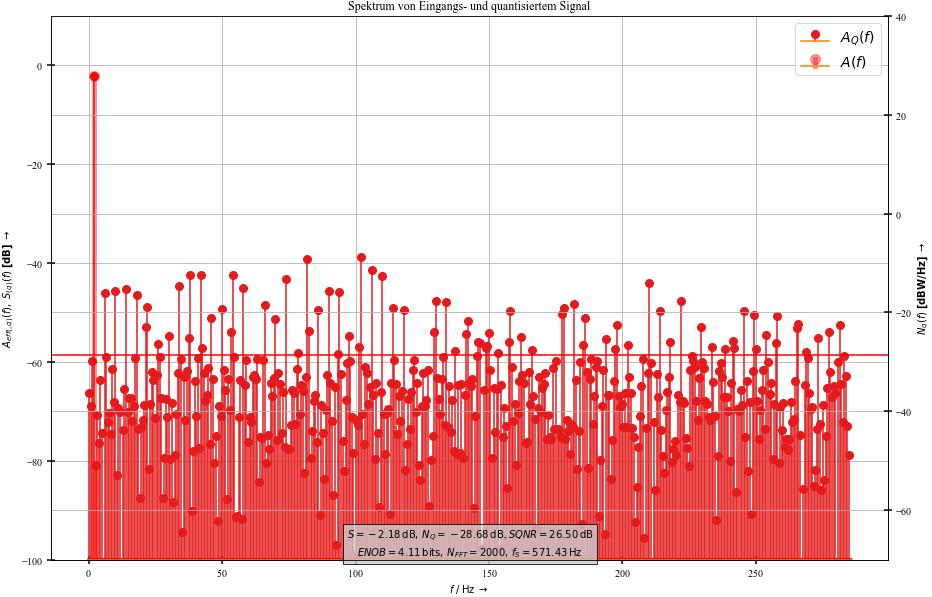

In [12]:
fig2 = figure(2, **figsize)
title('Spektrum von Eingangs- und quantisiertem Signal')
ax2 = fig2.add_subplot(111)
ax2.stem(f, 20 * log10(AQ), bottom = Amin, label = r'$A_Q(f)$')
ml, sl, bl = stem(f,  20 * log10(A), bottom = Amin, label = r'$A(f)$')
plt.setp(ml, 'markerfacecolor', 'r', 'markersize', 10 ,'alpha', 0.4) # Marker
plt.setp(sl, 'color','r', 'linewidth', 5, 'alpha', 0.4)    # Stemline
AQ[N_per] = abs(AQ[N_per] - A[N_per]) # Subtrahiere Signal
S = 10*log10(A[N_per]**2.)       # Signalleistung, gemessen
N_PSD = 10 * log10(np.average(AQ*AQ))   # mittlere Rauschleistungsdichte
NQ = N_PSD + 10*log10(NFFT/2)
ENOB = ((S-NQ) - 1.76)/6.02
# print(S, NQ, S - NQ)
plt.axhline(y = N_PSD) # plotte horiz. Linie mit mittlerer Rauschleist.dichte
ax2.set_xlabel(r'$f \; \mathrm{/ \; Hz} \; \rightarrow$')
ax2.set_ylabel(r'$A_{eff(,q)}(f), \;S_{(q)}(f)\; \mathbf{[dB]} \;\rightarrow$')
ax2.set_ylim(Amin,10)
plt.text(1/(4*T_S), Amin,
         r'$S = %.2f \, \mathrm{dB},\, N_Q = %.2f \, \mathrm{dB}$, '
         r'$SQNR = %.2f \, \mathrm{dB}$'%(S, NQ, S-NQ) + '\n' +
         r'$ENOB = %.2f \, \mathrm{bits},\, N_{FFT} = %d,\, f_S = %.2f\,'
         r'\mathrm{Hz}$'%(ENOB, NFFT, 1./T_S),
        ha='center', va='bottom', bbox=dict(facecolor='0.8', alpha=0.8))
     #
plt.legend(fontsize = 14)
if NOISE_LABEL:
    ax2b = ax2.twinx()
    ax2b.set_ylim(ax2.get_ylim()+ 10*log10(NFFT/2))
    ax2b.set_ylabel(r'$N_q(f)\;  \mathbf{[dBW / Hz]} \; \rightarrow$')

## Fragen und Experimente
Überlegen / überprüfen Sie jeweils:
- Passt die Formel $SQNR = (6.02 W + 1.76)$ dB ?
- Wie kann man den angezeigten mittleren Rauschpegel umrechnen in die Rauschleistung?

- Welches *SQNR* erwarten Sie bei den Quantisierungsparametern im Skript?
- Warum ergibt die Simulation einen schlechteren Wert? Welchen maximalen Wert können Sie erreichen?
- Legen Sie ein Sinussignal mit der halben maximalen Amplitude an den Quantisierer. Welche Signalleistung erwarten Sie, welches *SQNR* und welche *ENOB*?

- Erklären Sie, welchen Einfluss die Anzahl der dargestellten Signalperioden $N\_per$ im Code auf das dargestellte Spektrum hat. 



***
**Copyright**

(c) 2016 - 2019 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp_fpga "Digitale Signalverarbeitung auf FPGAs"

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing auf FPGAs - Vorlesungsunterlagen mit Simulationsbeispielen, 2019*.